In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import warnings

warnings.filterwarnings('ignore')
                        
sns.set_style('whitegrid')

In [2]:
five_rows=pd.read_csv('loans_2007.csv',nrows=5)
five_rows

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
sample=pd.read_csv('loans_2007.csv',nrows=1000)

# Too small memory per specfication: 

In [4]:
sample.memory_usage(deep=True).sum()/(2**20)

2.678302764892578

# Need to converge to a memory that is under 5 megabytes

* After minimizing the memory allocation for each column in the dataset

# Categorizing Columns

* Allows to minimize memory allocated to strings that have a small number of unique values:

In [5]:
def categorize_columns(df):
    
    obj_df=df.select_dtypes(include=['object'])
    
    categorize_li=[]
    
    rows=len(obj_df)
    
    for a in obj_df.columns:
        
        unique_vals_len=len(obj_df[a].unique())
        
        ratio=unique_vals_len/rows
        if ratio<0.5:
            categorize_li.append(a)
            
    for b in categorize_li:
        
        df[b]=df[b].astype('category')
            
    return df


# Downcasting Numbers:

* Minimizes the memory allocated to interpreted floats and integers.
    * Python automatically assumes the datatypes for the numeric values to be float64 or int64
    * Depending on the range of the values of each variable:
        * The numbers can be downcasted to a 16 or 32

In [6]:
def downcasting_numbers(df):
    
    types=['float','integer']
    
    for type_col in types:
        
        df_filt=df.select_dtypes(include=[type_col])
        
        for cols in df_filt.columns:
            
            df[cols]=pd.to_numeric(df[cols],downcast=type_col)
            
    return df
        

# Showing the memory saved by categorizing string columns and downcasting numeric columns:

In [7]:
five_rows=pd.read_csv('loans_2007.csv',nrows=5)
five_rows.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Columns: 145 entries, id to settlement_term
dtypes: float64(103), int64(17), object(25)
memory usage: 13.6 KB


In [8]:
categorize_columns(five_rows)
downcasting_numbers(five_rows)
five_rows.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Columns: 145 entries, id to settlement_term
dtypes: category(11), float32(103), int16(4), int32(1), int8(12), object(14)
memory usage: 9.4 KB


* Memory allocation dropped from 13.6 KB to 9.4 KB
* Approximately 30% reduction in dataframe memory

# Finding optimal size in every chunk read in while applying memory saving functions:

In [9]:
def find_optimal_size(chunksize,increment):
    
    max_val=0
    while True:
        print('Chunksize: '+str(chunksize))
        chunk_iter=pd.read_csv('loans_2007.csv',chunksize=chunksize)

        mem_size=[]

        for chunk in chunk_iter:

            categorize_columns(chunk)
            downcasting_numbers(chunk)

            memory_size=chunk.memory_usage(deep=True).sum()/(2**20)

            mem_size.append(memory_size)

        

        max_val=round(np.array(mem_size).max(),3)
        if max_val>5:
            break
            
        print(max_val)
        
        chunksize+=increment
        
    
    optimal_size=chunksize-increment
    
    chunk_iter=pd.read_csv('loans_2007.csv',chunksize=optimal_size)

    mem_size=[]

    for chunk in chunk_iter:
        categorize_columns(chunk)
        downcasting_numbers(chunk)

        memory_size=chunk.memory_usage(deep=True).sum()/(2**20)

        mem_size.append(memory_size)

    sns.distplot(mem_size)
    max_val=round(np.array(mem_size).max(),3)
    print('The max chunk memory size is: '+str(max_val)+' MB')
    
    return optimal_size

Chunksize: 4400
4.753
Chunksize: 4450
4.909
Chunksize: 4500
4.938
Chunksize: 4550
4.968
Chunksize: 4600
The max chunk memory size is: 4.968 MB


4550

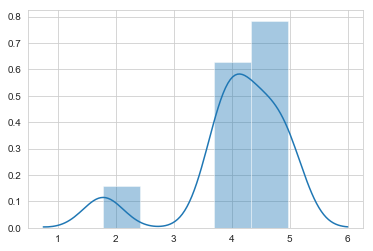

In [10]:
find_optimal_size(4400,50)

# The determined optimal chunk size to do operations is 4550 rows